## Open notebook in:
| Colab                                 
:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolepcx/transformers-the-definitive-guide/blob/master/CH06/ch06_wave_and_spectograms_plots.ipynb)                                             

# About this Notebook

This notebook showcases the process of **generating and analyzing music** using Meta’s **MusicGen** model (`facebook/musicgen-large`) from the Hugging Face `transformers` and `diffusers` libraries. It includes not only the **text-to-music generation pipeline**, but also a detailed **audio analysis** section using `librosa`, making it a comprehensive guide for audio synthesis and evaluation.

### Steps Included:

1. **Prompt-Based Audio Generation**:

   * The notebook creates prompt-based generation with various genres (e.g., *classical*, *EDM*, *minimal*) using descriptive text prompts.
   * The audio is generated as a 3D tensor and exported to `.wav` files using `scipy`.

2. **Audio Export and Playback**:

   * The generated audio is normalized, converted to 16-bit PCM, and saved using `scipy.io.wavfile.write`.
   * `IPython.display.Audio` is used for inline playback to easily inspect output quality.

3. **Audio Segmentation and Tempo Estimation**:

   * Using `librosa`, the notebook performs **beat tracking**, **onset detection**, and **agglomerative segmentation** to analyze rhythmic structures in generated tracks.
   * These analyses are visualized over waveforms to highlight tempo (in BPM) and segment boundaries.

4. **Spectral Analysis and Visualization**:

   * For selected genres (e.g., *EDM*, *Classical*), the notebook generates and compares:

     * **Short-Time Fourier Transform (STFT) Spectrograms**
     * **Mel-Spectrograms**
   * These visualizations offer insights into frequency distribution and timbral content.

5. **Real-World Signal Example**:

   * As a final comparison, the notebook loads a real trumpet recording and applies:

     * **FFT (frequency spectrum)**
     * **Spectrogram**
     * **Mel-Spectrogram**


# Installs

In [1]:
!pip install transformers datasets[audio] -qqq

# Imports

In [2]:
import torch
import scipy
from IPython.display import Audio
from transformers import AutoProcessor
from scipy.io.wavfile import write as write_wav
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from transformers import MusicgenForConditionalGeneration


# Load model

In [3]:

model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-large")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.73G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

# Prepare audio output

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device);

In [7]:
unconditional_inputs = model.get_unconditional_inputs(num_samples=1)

audio_values = model.generate(**unconditional_inputs, do_sample=True, max_new_tokens=256)

In [8]:

sampling_rate = model.config.audio_encoder.sampling_rate
Audio(audio_values[0].cpu().numpy(), rate=sampling_rate)

print(sampling_rate)

32000


# Load processor

In [5]:

processor = AutoProcessor.from_pretrained("facebook/musicgen-large")


preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

# Generate audio of different genre

In [9]:
# Define genres and prompts
genre_prompts = {
    "classical": "classical piano music",
    "minimal": "minimal house rather monoton in rhythm",
    "EDM": "EDM hardcore Techno sound",
}

# Generate and save each audio
for genre, prompt in genre_prompts.items():
    # Prepare input
    inputs = processor(text=[prompt], padding=True, return_tensors="pt").to(device)

    # Generate audio
    audio_values = model.generate(
        **inputs,
        do_sample=True,
        guidance_scale=3,
        max_new_tokens=1024
    )

    # Convert to numpy and clip
    audio_np = audio_values[0].cpu().numpy().squeeze()
    audio_np = np.clip(audio_np, -1.0, 1.0)
    audio_int16 = (audio_np * 32767).astype(np.int16)

    # Save as WAV
    filename = f"{genre}.wav"
    write_wav(filename, sampling_rate, audio_int16)

    # Optionally play back
    display(Audio(audio_np, rate=sampling_rate))


# Plot wav file

/tmp/ipython-input-28-1772024786.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'{title} - Tempo: {float(tempo):.2f} BPM')
/tmp/ipython-input-28-1772024786.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'{title} - Tempo: {float(tempo):.2f} BPM')
/tmp/ipython-input-28-1772024786.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'{title} - Tempo: {float(tempo):.2f} BPM')


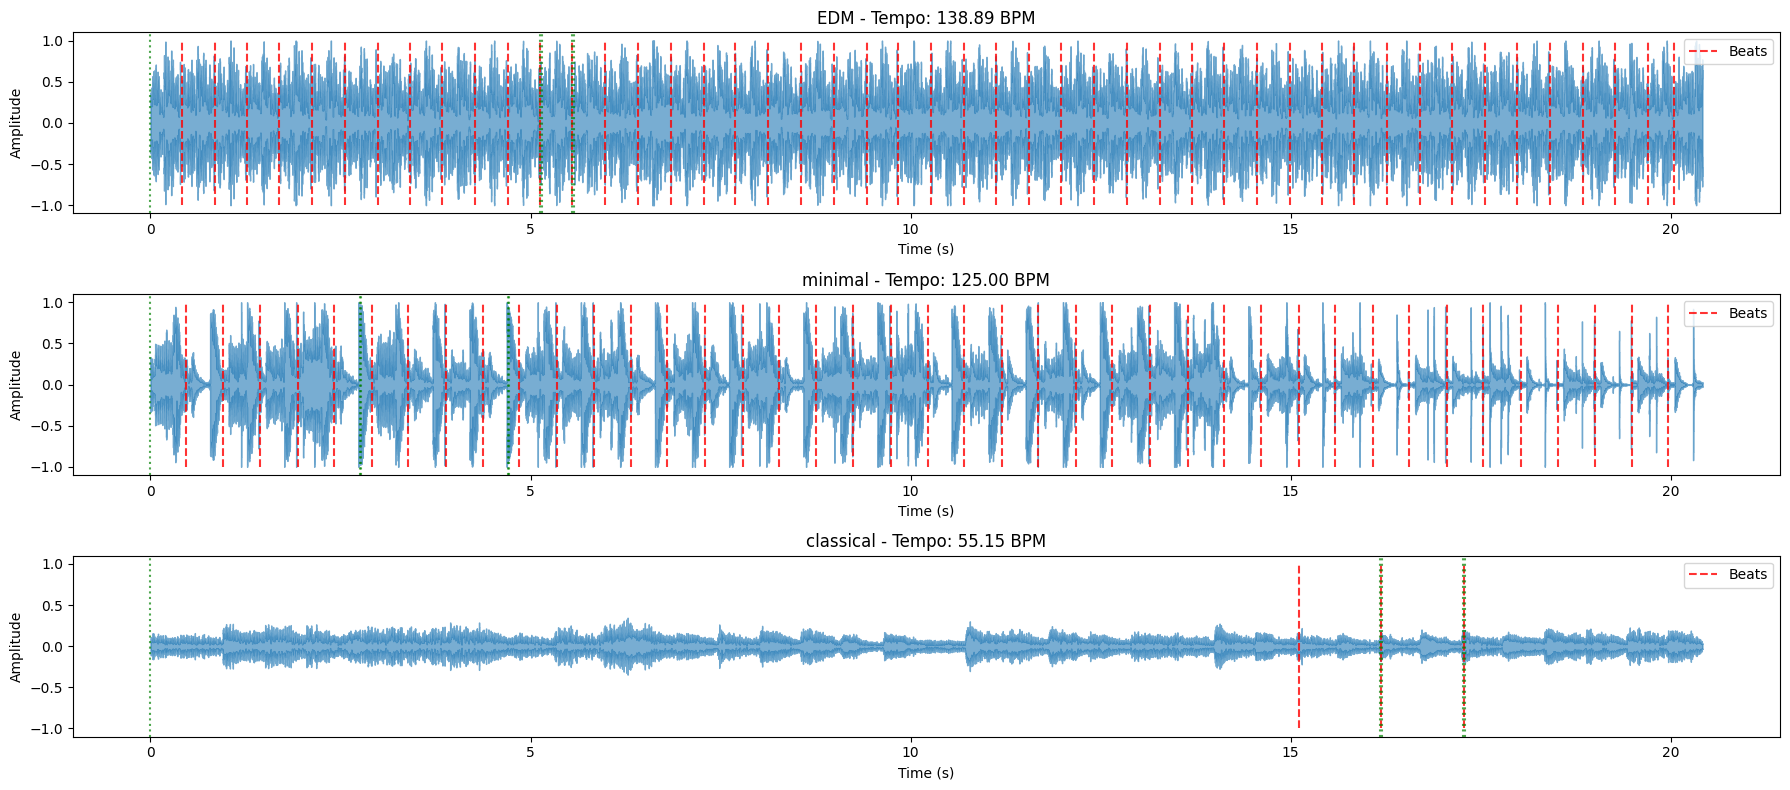

In [ ]:
# List of filenames
filenames = ['EDM.wav', 'minimal.wav', 'classical.wav']
titles = ['EDM', 'minimal', 'classical']

# Prepare plot
plt.figure(figsize=(18, 8))

for i, (filename, title) in enumerate(zip(filenames, titles)):
    # Load audio
    y, sr = librosa.load(filename, sr=None)

    # Beat tracking
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
    beat_times = librosa.frames_to_time(beats, sr=sr)

    # Onset-based segmentation
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    segments = librosa.segment.agglomerative(onset_env.reshape(1, -1), k=5)
    seg_times = librosa.frames_to_time(segments, sr=sr)

    # Subplot for each sound
    plt.subplot(3, 1, i + 1)
    librosa.display.waveshow(y, sr=sr, alpha=0.6)

    # Overlay beats
    plt.vlines(beat_times, -1, 1, color='r', alpha=0.8, linestyle='--', label='Beats')

    # Overlay segments
    for seg_time in seg_times:
        plt.axvline(seg_time, color='g', linestyle=':', alpha=0.7)

    plt.title(f'{title} - Tempo: {float(tempo):.2f} BPM')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


# Plot Spectrogram and Mel-Spectrogram

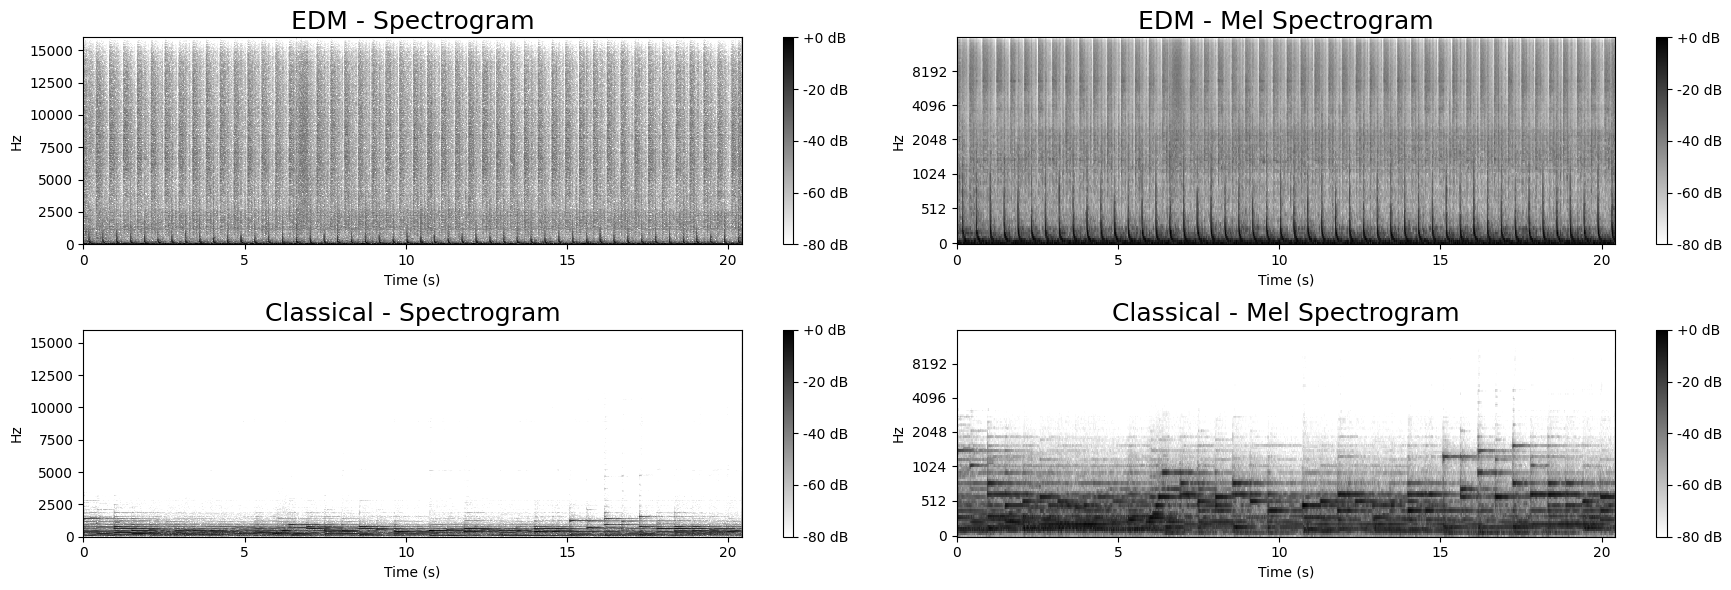

In [ ]:


# Audio files and labels
filenames = ['EDM.wav', 'classical.wav']
titles = ['EDM', 'Classical']

# Slightly compressed vertical layout
plt.figure(figsize=(18, 6))

for i, (file, title) in enumerate(zip(filenames, titles)):
    y, sr = librosa.load(file, sr=None)

    # Spectrogram
    plt.subplot(2, 2, 2 * i + 1)
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='gray_r')
    plt.colorbar(format="%+2.0f dB")
    plt.xlabel('Time (s)')
    plt.title(f"{title} - Spectrogram", fontsize=18)

    # Mel-Spectrogram
    plt.subplot(2, 2, 2 * i + 2)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='gray_r')
    plt.colorbar(format="%+2.0f dB")
    plt.xlabel('Time (s)')
    plt.title(f"{title} - Mel Spectrogram", fontsize=18)

plt.tight_layout()
plt.show()


# Plot frequency spectrum

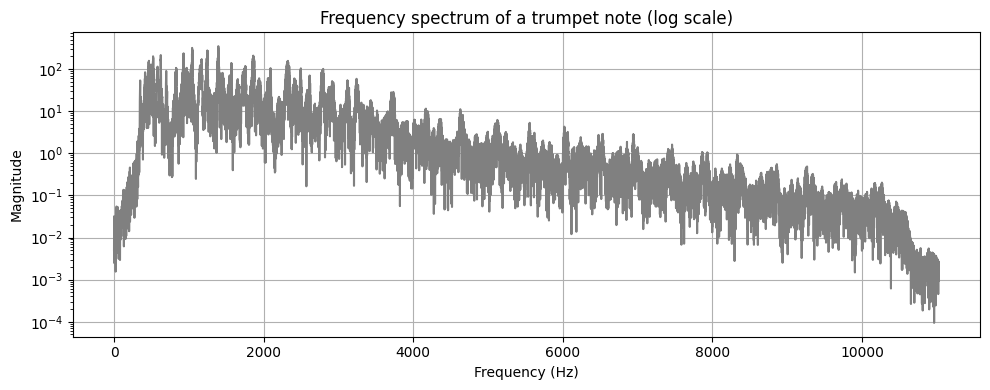

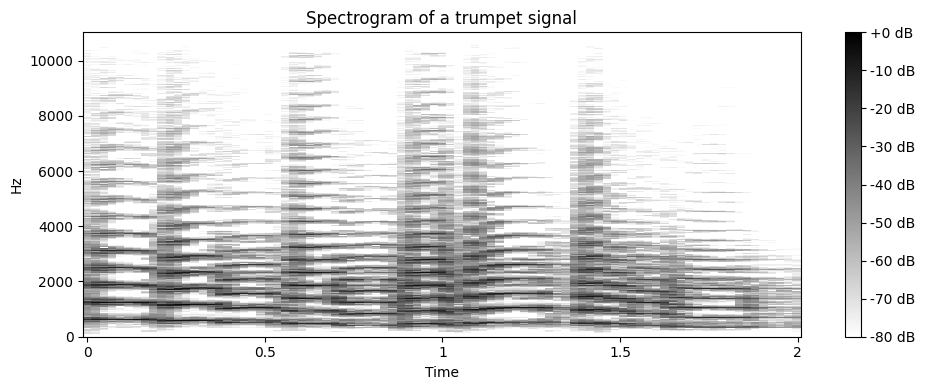

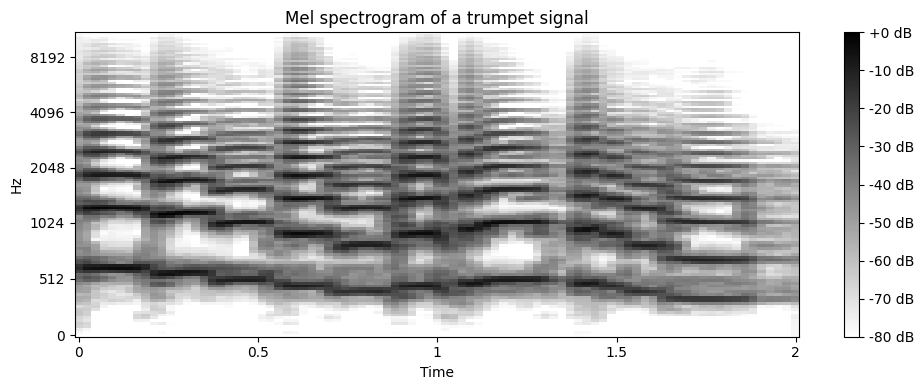

In [ ]:


# Load example trumpet signal
y, sr = librosa.load(librosa.ex('trumpet'), duration=2.0)

# Frequency spectrum (DFT) ===
plt.figure(figsize=(8, 4))
D = np.fft.fft(y)
frequencies = np.fft.fftfreq(len(D), d=1/sr)
magnitude = np.abs(D)

plt.plot(frequencies[:len(frequencies)//2], magnitude[:len(magnitude)//2], color="gray")
plt.title('Frequency spectrum of a trumpet note (log scale)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

# Spectrogram using STFT ===
plt.figure(figsize=(10, 4))
S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
S_db = librosa.amplitude_to_db(S, ref=np.max)

librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='gray_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of a trumpet signal')
plt.tight_layout()
plt.show()

# Mel Spectrogram ===
plt.figure(figsize=(10, 4))
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel', cmap='gray_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram of a trumpet signal')
plt.tight_layout()
plt.show()
